In [89]:
# (1) Import the required Python dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from skimage import img_as_float

import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector

In [90]:
# (2) Instantiate a Spark Context
conf = SparkConf().setMaster("spark://192.168.56.10:7077").setAppName("K-Means Clustering - Image Segmentation")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

Text(0.5,1,'MRI Scan of a HEALTHY Brain to TRAIN our Unsupervised K-Means Clustering Model\n')

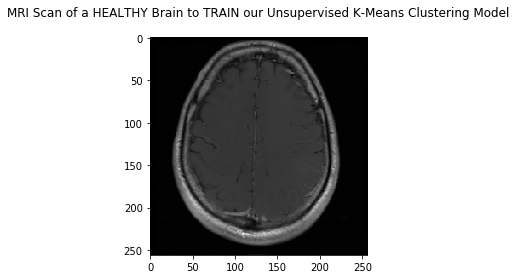

In [91]:
# (3) Load the MRI scan belonging to the HEALTHY brain
mri_healthy_brain_image = io.imread('/data/workspaces/jillur.quddus/jupyter/notebooks/Machine-Learning-with-Apache-Spark-QuickStart-Guide/chapter05/data/mri-images-data/mri-healthy-brain.png')
mri_healthy_brain_image_plot = plt.imshow(mri_healthy_brain_image, cmap='gray')
plt.title("MRI Scan of a HEALTHY Brain to TRAIN our Unsupervised K-Means Clustering Model\n")

In [92]:
# (4) Convert our Training MRI Scan into a Matrix of pixel intensity values between 0 and 1
mri_healthy_brain_matrix = img_as_float(mri_healthy_brain_image)
print("Healthy MRI Scan - MATRIX of Pixel Intensity Values: \n")
print(mri_healthy_brain_matrix)
print("\nHealthy MRI Scan - MATRIX Dimensions (width x height in px): \n")
print(mri_healthy_brain_matrix.shape)

Healthy MRI Scan - MATRIX of Pixel Intensity Values: 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Healthy MRI Scan - MATRIX Dimensions (width x height in px): 

(256, 256)


In [93]:
# (5) Convert the Matrix into a Flattened Vector i.e. Matrix of dimensions 1 x N
mri_healthy_brain_2d_array = np.array(mri_healthy_brain_matrix).astype(float)
mri_healthy_brain_1d_array = mri_healthy_brain_2d_array.ravel()
mri_healthy_brain_vector = np.matrix(mri_healthy_brain_1d_array)

print("Healthy MRI Scan - Flattened Vector i.e. Matrix of Dimensions 1 x N: \n")
print(mri_healthy_brain_vector)
print("\nHealthy MRI Scan - Flattened Vector Dimensions: \n")
print(mri_healthy_brain_vector.shape)

Healthy MRI Scan - Flattened Vector i.e. Matrix of Dimensions 1 x N: 

[[0. 0. 0. ... 0. 0. 0.]]

Healthy MRI Scan - Flattened Vector Dimensions: 

(1, 65536)


In [94]:
# (6) Convert the Flattened Vector into a Spark DataFrame where each Row corresponds to a single pixel intensity value
mri_healthy_brain_vector_transposed = mri_healthy_brain_vector.reshape(
    mri_healthy_brain_vector.shape[1], mri_healthy_brain_vector.shape[0])
print("Healthy MRI Scan - Transposed Vector i.e. Matrix of Dimensions N x 1: ")
print(mri_healthy_brain_vector_transposed)
print("\nHealthy MRI Scan - Transposed Vector Dimensions: \n")
print(mri_healthy_brain_vector_transposed.shape)

mri_healthy_brain_df = sqlContext.createDataFrame(pd.DataFrame(mri_healthy_brain_vector_transposed, columns=['pixel_intensity']))
print("\nHealthy MRI Scan - \033[1m\033[4mDISTRIBUTED\033[0m Spark DataFrame of Pixel Intensity Values: \n")
mri_healthy_brain_df.show()
mri_healthy_brain_df.dtypes

Healthy MRI Scan - Transposed Vector i.e. Matrix of Dimensions N x 1: 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

Healthy MRI Scan - Transposed Vector Dimensions: 

(65536, 1)

Healthy MRI Scan - DISTRIBUTED Spark DataFrame of Pixel Intensity Values: 

+---------------+
|pixel_intensity|
+---------------+
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
+---------------+
only showing top 20 rows



[('pixel_intensity', 'double')]

In [95]:
# (7) Generate Input Feature Vectors from the Pixel Intensity Values Spark DataFrame
feature_columns = ['pixel_intensity']
vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
print("Healthy MRI Scan - Pixel Intensity Feature Vectors: \n")
mri_healthy_brain_features_df = vector_assembler.transform(mri_healthy_brain_df).select('features')
mri_healthy_brain_features_df.show()
mri_healthy_brain_features_df.dtypes

Healthy MRI Scan - Pixel Intensity Feature Vectors: 

+--------+
|features|
+--------+
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
+--------+
only showing top 20 rows



[('features', 'vector')]

Text(0,0.5,'K-Means Cost')

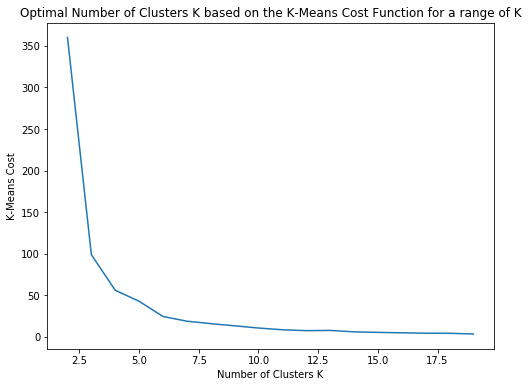

In [96]:
# (8) Determine the optimal number of clusters K by examining the K-Means Cost for a range of K
cost = np.zeros(20)
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(mri_healthy_brain_features_df.sample(False, 0.1, seed=12345))
    cost[k] = model.computeCost(mri_healthy_brain_features_df)

fig, ax = plt.subplots(1, 1, figsize =(8, 6))
ax.plot(range(2, 20),cost[2:20])
ax.set_title('Optimal Number of Clusters K based on the K-Means Cost Function for a range of K')
ax.set_xlabel('Number of Clusters K')
ax.set_ylabel('K-Means Cost')

In [97]:
# (9) Train a K-Means Clustering Model based on the Pixel Intensity Feature Vectors of a Healthy MRI Brain Scan
k = 5
kmeans = KMeans().setK(k).setSeed(12345).setFeaturesCol("features")
kmeans_model = kmeans.fit(mri_healthy_brain_features_df)
kmeans_centers = kmeans_model.clusterCenters()
print("Healthy MRI Scan - K-Means Cluster Centers: \n")
for center in kmeans_centers:
    print(center)

Healthy MRI Scan - K-Means Cluster Centers: 

[0.01053562]
[0.20742082]
[0.59427134]
[0.42359628]
[0.31779411]


Healthy MRI Scan - Pixels mapped to 1 ... K Clusters (K = 5): 

+--------+----------+
|features|prediction|
+--------+----------+
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
+--------+----------+
only showing top 20 rows


Healthy MRI Scan - Cluster Visualisation: 



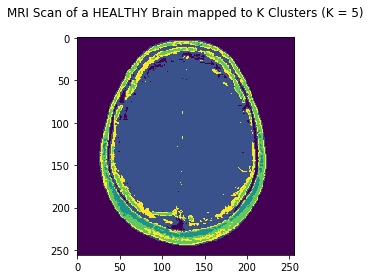

In [98]:
# (10) Assign Pixels to Clusters in the HEALTHY MRI Brain Scan Image and visualise these K Clusters
mri_healthy_brain_clusters_df = kmeans_model.transform(mri_healthy_brain_features_df).select('features', 'prediction')
print("Healthy MRI Scan - Pixels mapped to 1 ... K Clusters (K = %d): \n" % k)
mri_healthy_brain_clusters_df.show()
print("\nHealthy MRI Scan - Cluster Visualisation: \n")
mri_healthy_brain_clusters_matrix = mri_healthy_brain_clusters_df.select("prediction").toPandas().values.reshape(
    mri_healthy_brain_matrix.shape[0], mri_healthy_brain_matrix.shape[1])
plt.imshow(mri_healthy_brain_clusters_matrix)
plt.title("MRI Scan of a HEALTHY Brain mapped to K Clusters (K = %d)\n" % k)
plt.show()

Text(0.5,1,'MRI Scan of another Brain to TEST our Unsupervised K-Means Clustering Model\n')

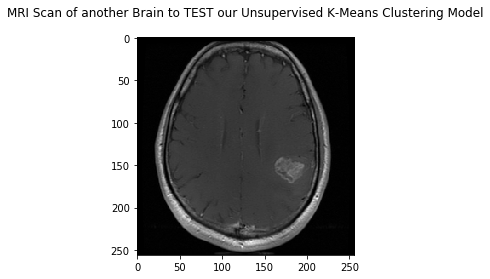

In [99]:
# (11) Load an MRI Scan belonging to another Brain to Test our K-Means Clustering Model
mri_test_brain_image = io.imread('/data/workspaces/jillur.quddus/jupyter/notebooks/Machine-Learning-with-Apache-Spark-QuickStart-Guide/chapter05/data/mri-images-data/mri-test-brain.png')
mri_test_brain_image_plot = plt.imshow(mri_test_brain_image, cmap='gray')
plt.title("MRI Scan of another Brain to TEST our Unsupervised K-Means Clustering Model\n")

\Test MRI Scan - Cluster Visualisation: 



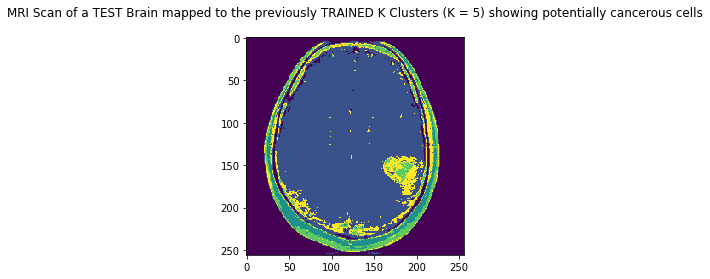

In [100]:
# (12) Apply the trained K-Means Clustering Model to the TEST MRI Scan
# The following code can be parameterised via Python functions to reduce code duplication
mri_test_brain_matrix = img_as_float(mri_test_brain_image)
mri_test_brain_2d_array = np.array(mri_test_brain_matrix).astype(float)
mri_test_brain_1d_array = mri_test_brain_2d_array.ravel()
mri_test_brain_vector = np.matrix(mri_test_brain_1d_array)
mri_test_brain_vector_transposed = mri_test_brain_vector.reshape(
    mri_test_brain_vector.shape[1], mri_test_brain_vector.shape[0])
mri_test_brain_df = sqlContext.createDataFrame(pd.DataFrame(mri_test_brain_vector_transposed, columns=['pixel_intensity']))
mri_test_brain_features_df = vector_assembler.transform(mri_test_brain_df).select('features')

mri_test_brain_clusters_df = kmeans_model.transform(mri_test_brain_features_df).select('features', 'prediction')
print("\Test MRI Scan - Cluster Visualisation: \n")
mri_test_brain_clusters_matrix = mri_test_brain_clusters_df.select("prediction").toPandas().values.reshape(
    mri_test_brain_matrix.shape[0], mri_test_brain_matrix.shape[1])
plt.imshow(mri_test_brain_clusters_matrix)
plt.title("MRI Scan of a TEST Brain mapped to the previously TRAINED K Clusters (K = %d) showing potentially cancerous cells\n" % k)
plt.show()

In [101]:
# (13) Stop the Spark Context
sc.stop()